<a href="https://www.kaggle.com/code/nishantsinghsiddhu/transfer-learning-resnet-95-accuracy?scriptVersionId=117465384" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

print('total have tumor images:', len(os.listdir(yes_dir)))
print('total no tumor images:', len(os.listdir(no_dir)))

total have tumor images: 155
total no tumor images: 98


In [3]:
yes_files = os.listdir(yes_dir)
print(yes_files[:10])

no_files = os.listdir(no_dir)
print(no_files[:10])

['Y115.JPG', 'Y192.JPG', 'Y162.jpg', 'Y9.jpg', 'Y108.jpg', 'Y155.JPG', 'Y106.jpg', 'Y258.JPG', 'Y103.jpg', 'Y185.jpg']
['34 no.jpg', 'N20.JPG', 'N1.JPG', '49 no.jpg', 'N15.jpg', 'No18.jpg', '31 no.jpg', 'no 6.jpg', '3 no.jpg', 'no 5.jpeg']


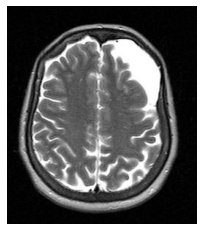

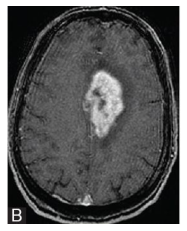

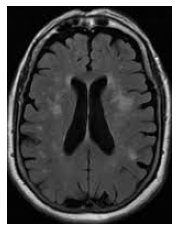

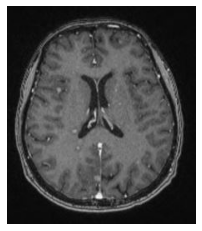

In [4]:
%matplotlib inline

pic_index = 2

next_yes = [os.path.join(yes_dir, fname) 
                for fname in yes_files[pic_index-2:pic_index]]
next_no = [os.path.join(no_dir, fname) 
                for fname in no_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_yes+next_no):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [5]:
dataset=[]
target=[]
for image_name in yes_files:
    image=cv2.imread(yes_dir + '/' +image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(1)
    
for image_name in no_files:
    image=cv2.imread(no_dir + '/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((64,64))
    dataset.append(np.array(image))
    target.append(0)

In [6]:
data = np.array(dataset)
target = np.array(target)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,target,test_size=0.05,random_state=True) 

In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

def preprocess_data(X):
    X_p = tf.keras.applications.resnet50.preprocess_input(X)
    return X_p

In [9]:

def resnet_model(X, augmentation=data_augmenter()):
    '''
    classification model
    '''
    
#     input_shape = X[0].shape
    
    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)
    
    model.trainable = False
    
    inputs = tf.keras.Input(shape=X[0].shape)
    
    x = augmentation(inputs)
    
    x = preprocess_data(x)
    
    x = model(x, training= False)
    
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.4)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    mod = tf.keras.Model(inputs, outputs)
    
    return mod
    
    
    

2023-01-27 14:27:33.047287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:27:33.048610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:27:33.207866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:27:33.209285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:27:33.210555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [10]:
resNet = resnet_model(X_train, augmentation=data_augmenter())

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
resNet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 64, 64, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [12]:
base_learning_rate = 0.0001
resNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
initial_epochs = 50
history = resNet.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50


2023-01-27 14:27:39.489989: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-27 14:27:44.030967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 13s 248ms/step - loss: 2.7903 - accuracy: 0.4375 - val_loss: 1.8328 - val_accuracy: 0.5385
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 2.2565 - accuracy: 0.4167 - val_loss: 1.4399 - val_accuracy: 0.5385
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 1.6119 - accuracy: 0.4333 - val_loss: 1.1620 - val_accuracy: 0.6154
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 1.4623 - accuracy: 0.5458 - val_loss: 1.0241 - val_accuracy: 0.6154
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 1.2683 - accuracy: 0.5083 - val_loss: 0.9628 - val_accuracy: 0.6154
Epoch 6/50
8/8 [==============================] - 0s 24ms/step - loss: 1.1056 - accuracy: 0.6042 - val_loss: 0.9286 - val_accuracy: 0.6154
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 1.2824 - accuracy: 0.5458 - val_loss: 0.8969 - val_accuracy: 0.6923
Epoch 8/50
8/8 [====================

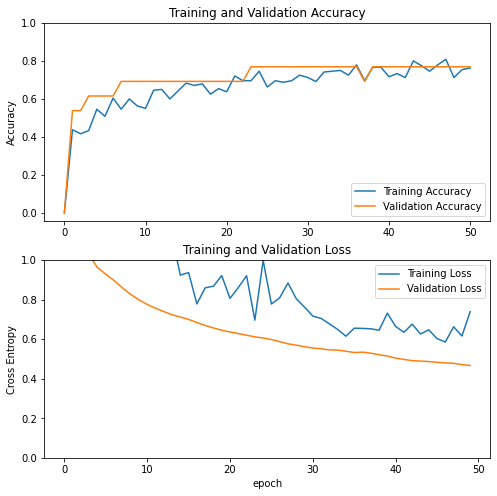

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:

def resnet_model_2(X, augmentation=data_augmenter()):
    '''
    classification model
    '''
    
#     input_shape = X[0].shape
    
    model_2 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=X[0].shape)
    
    # Fine-tune from this layer onwards
    fine_tune_at = 165


    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model_2.layers[:fine_tune_at]:
        #print('Layer ' + layer.name + ' frozen.')
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=X[0].shape)
    
    x = augmentation(inputs)
    
    x = preprocess_data(x)
    
    x = model_2(x)
    
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.6)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1,activation="sigmoid")
    
    outputs = prediction_layer(x) 
    mod_2 = tf.keras.Model(inputs, outputs)
    
    return mod_2

In [16]:
resNet_2 = resnet_model_2(X_train, augmentation=data_augmenter())

In [17]:
resNet_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 64, 64, 3)         0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [18]:
resNet_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
initial_epochs = 50
history_2 = resNet_2.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=initial_epochs)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


8/8 [==============================] - 6s 183ms/step - loss: 1.3812 - accuracy: 0.5500 - val_loss: 0.9618 - val_accuracy: 0.4615
Epoch 2/50
8/8 [==============================] - 0s 29ms/step - loss: 1.2392 - accuracy: 0.5583 - val_loss: 0.5109 - val_accuracy: 0.6923
Epoch 3/50
8/8 [==============================] - 0s 27ms/step - loss: 0.8515 - accuracy: 0.6583 - val_loss: 0.3523 - val_accuracy: 0.7692
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 0.6104 - accuracy: 0.7792 - val_loss: 0.2996 - val_accuracy: 0.8462
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.6780 - accuracy: 0.7458 - val_loss: 0.2610 - val_accuracy: 0.9231
Epoch 6/50
8/8 [==============================] - 0s 27ms/step - loss: 0.5006 - accuracy: 0.7792 - val_loss: 0.2686 - val_accuracy: 0.9231
Epoch 7/50
8/8 [==============================] - 0s 28ms/step - loss: 0.4846 - accuracy: 0.8167 - val_loss: 0.3000 - val_accuracy: 0.9231
Epoch 8/50
8/8 [=====================

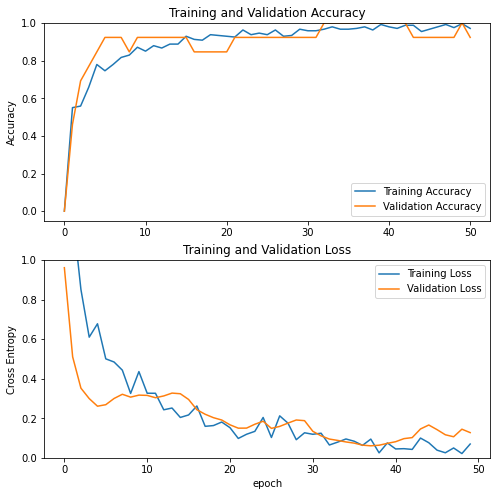

In [20]:
acc = [0.] + history_2.history['accuracy']
val_acc = [0.] + history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()